# Project: Dog Identification App 

In [1]:
import os
import sys
import numpy as np
import joblib as jb
import matplotlib.pyplot as plt
from glob import glob

import torch
import torch.nn.functional as F
import torch.optim as optim
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from torchvision import datasets
from facenet_pytorch import MTCNN 

from PIL import Image, ImageFile

# the following import is required for training to be robust to truncated images
ImageFile.LOAD_TRUNCATED_IMAGES = True

# check if CUDA is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

%matplotlib inline

## Create Dog Image Data Loaders

* Training DataLoader
    * Transforms
    * Normalize
    * Image Augmentation


* Validation DataLoader
    * Transforms
    * Normalize


* Testing DataLoader
    * Transforms
    * Normalize
  
  
__Since the image domain I'm using is similar to ImageNet, I'm using the same mean and standard deviation \
to normalize pixel values. Also, I decided to use the 224 by 224 image size as it's small enough to allow \
me to train a batchs of images on my NVIDIA GPU that has 4 gigabytes memorry, but large enough to \
maintain details from the original image__
    
* VGG16 expects a 224 by 224 pixel images. \
    Online, I noticed it's considered a good practice to resize the images to 256 by 256, \
    then cropping the center 224 by 224 area. Additionally, the VGG archticture expects the pixel values \
   to be normalized differently each color channel. mean = [0.485, 0.456, 0.406], and std=[0.229, 0.224, 0.225]

__The training set contains 6680 images. That's a small number of images considering the number of classes. \
Since the model is likely to overfit before achieving an acceptable classification accuracy, I decided to perform 
image augmentation.__

* I randomly crop a 224 by 224 pixel area of the picture which would likely move
    what I want to classify in the images around (translation invariance) \
    Also, I rotate and flip the images (rotation invariance). Finally, I'm experementing with Gaussian Blur. \
    Since not everyone is great at taking pictures I'm expecting low quality user images. \
    Hopefully, this will help make the model more robust to blurry images.



    

In [4]:
# define hyper parameters
DATA_DIR = 'dogImages/'
TRAIN = 'train'
VAL = 'valid'
TEST = 'test'
KERNEL_SIZE = 3
SIGMA = (0.3, 1.8)
ROTATION = 30
RESIZE = (256, 256)
CROP = (224, 224)
BATCH_SIZE = 6
EPOCHS = 1

data_transforms = { 
    TRAIN: transforms.Compose([ # define train set augmentations
        transforms.Resize(RESIZE),
        transforms.RandomCrop(CROP),
        transforms.RandomVerticalFlip(),
        transforms.RandomRotation(ROTATION),
        transforms.RandomHorizontalFlip(),
        transforms.GaussianBlur(KERNEL_SIZE, sigma=SIGMA),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ]),
    VAL: transforms.Compose([ # no need to perform any augmentation on the validation data
        transforms.Resize(RESIZE),
        transforms.CenterCrop(CROP),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ]),
    TEST: transforms.Compose([ # no need to perform any augmentation on the test data
        transforms.Resize(RESIZE),
        transforms.CenterCrop(CROP),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])
}

image_datasets = {
    x: datasets.ImageFolder(
        os.path.join(DATA_DIR, x), 
        transform=data_transforms[x]
    )
    for x in [TRAIN, VAL, TEST]
}

# create data loaders dictionary
loaders = {
    x: torch.utils.data.DataLoader(
        image_datasets[x], batch_size=BATCH_SIZE,
        shuffle=True, num_workers=0  # turn on shuffle (though not needed for testing and validation)
    ) 
    for x in [TRAIN, VAL, TEST]
}

# sanity check
for dataset in image_datasets:
    n_images = len(image_datasets[dataset])
    print(f'Dataset {dataset} contains {n_images} images')

Dataset train contains 6680 images
Dataset valid contains 835 images
Dataset test contains 836 images


## Train and Validate, and Test the Model

In [ ]:
# define training procedure
def train(n_epochs, loaders, model, 
          optimizer, criterion, device, save_path):     
    '''
    Trains and saves a PyTorch model
    inputs:
        n_epochs: int, number of epochs to train 
        loaders: dictionary containing at least two keys ('train', 'valid') and the respective DataLoaders as values
        model: pytorch modek class 
        optimizer: torch.optim, step optimizer  
        criterion: defined loss function 
        device: torch.device('cpu'), or torch.device('cuda')
        save_path: string, path to save the trained model
    
    '''
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf 
    train_batches = int(np.ceil(len(loaders['train'])))
    model = model.to(device)
    
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        total = 0
        train_loss = 0.0
        valid_loss = 0.0
        correct_acc = 0.0
        correct_valid = 0.0
        
        ###################
        # train the model #
        ###################
        
        model.train()
        for batch_idx, (data, target) in enumerate(loaders['train']):
            
            # move to GPU
            data, target = data.to(device), target.to(device)
            
            # reset optimizer every iteration
            optimizer.zero_grad()
            
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            
            # predict
            _, pred = torch.max(output, 1)
           
            equals = pred == target
            correct_acc += torch.sum(equals.type(torch.cuda.FloatTensor)).item()
            train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.item() - train_loss))
            total += target.size(0)
            
            sys.stdout.write('\r')
            sys.stdout.write(f"Epoch: {epoch}\tTraining batch {batch_idx} out of {train_batches}\tClassified correctly: {round(correct_acc / total, 5)}")
            sys.stdout.flush()
            
        ##############################    
        # validate model performance #
        ##############################
        
        with torch.no_grad():
            model.eval()
            for batch_idx, (data, target) in enumerate(loaders['valid']):
                
                # move to GPU
                data, target = data.to(device), target.to(device)
                
                ## update the average validation loss
                output = model(data)
                loss = criterion(output, target)
                
                _, pred = torch.max(output, 1)
                equals = pred == target
                correct_valid += torch.sum(equals.type(torch.cuda.FloatTensor)).item()
                valid_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.item() - train_loss))
                
                
        # print training/validation statistics 
        print('\nEpoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f} \t Training accuracy: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss,
            correct_acc / total
            ))
        
        ## save the model if validation loss has decreased
        if valid_loss < valid_loss_min:
            torch.save(model, save_path)
            print(f'\nValidation loss improved from {valid_loss_min} to {valid_loss}')
            valid_loss_min = valid_loss
        else: 
            print("Validation loss hasn't improved. Model not saved\n")
    
    # make sure to free up gpu memory
    data, target = data.to(torch.device('cpu')), target.to(torch.device('cpu'))
    model = model.to(torch.device('cpu'))
    return 

# define test procedure
def test(loaders, model, criterion, device):
    '''
    tests a PyTorch model
    inputs:
        loaders: dictionary containing at least one key ('test') and it's respective DataLoader as value
        model: pytorch modek class  
        criterion: defined loss function 
        device: torch.device('cpu'), or torch.device('cuda')   
    '''
    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.
    model = model.to(device)
    
    model.eval()
    for batch_idx, (data, target) in enumerate(loaders['test']):
        
        # move to gpu
        data, target = data.to(device), target.to(device)
        
        
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        
        # calculate the loss
        loss = criterion(output, target)
        
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print(f'Model loss: {test_loss}')
    print(f'Model accuracy: {round(100. * correct / total, 2)}% ({int(correct)}/{int(total)})')
    
    # make sure to free up gpu memory
    data, target = data.to(torch.device("cpu")), target.to(torch.device("cpu"))
    model = model.to(torch.device("cpu"))
    return

In [ ]:
# use pre-trained VGG16 
model_transfer = models.vgg16(pretrained=True)

# freeze layers
for param in model_transfer.features.parameters():
    param.require_grad = False
    
# remove last layer
classifier_block = model_transfer.classifier

num_features = model_transfer.classifier[-1].in_features # save the number of in features in the last layer
classifier_block = list(classifier_block[:-1]) # remove last layer

# replace the layer with a new output with the number of classes
classifier_block.extend([nn.Linear(num_features, 133)])

# replace classifier layer
model_transfer.classifier = nn.Sequential(*classifier_block)

## Model Training

In [ ]:
# multiclass classification - PyTorch implemntation of CrossEntropyLoss applies Softmax and NLLLoss
criterion = nn.CrossEntropyLoss()

# Adam optimizer typically outperforms other optimizers (true for the time this was written)
optimizer = optim.Adam(model_transfer.parameters(), 1e-4)

# train the model
train(EPOCHS, loaders, model_transfer, optimizer, criterion, device, 'model_transfer.pt')

## Test the Model

In [ ]:
# load the model that got the best validation accuracy (uncomment the line below)
model_transfer = torch.load('model_transfer.pt')
test(loaders, model_transfer, criterion, device)

In [ ]:
# create class dictionary to access labels more easily later
## list of class names by index, i.e. a name can be accessed like class_names[0]
class_names = [item[4:].replace("_", " ") for item in image_datasets['train'].classes]
class_names = {i: class_names[i] for i in range(133)}
jb.dump(class_names, 'class_names.pkl')

## Breed Classifier Outline

- if a __dog__ is detected in the image, return the predicted breed.
- if a __human__ is detected in the image, return the resembling dog breed.
- if __neither__ is detected in the image, provide output that indicates an error.

In [2]:
def face_detector(image_path: str) -> float:
    '''
    using pretrained VGG_FACE2 model to detect faces
    '''
    # check if CUDA is available
    cuda = torch.cuda.is_available()

    # load image
    image = Image.open(image_path).convert('RGB') # ensure color image
    
    # create a face detection pipeline using MTCNN (suggested parameters):
    mtcnn = MTCNN(
        image_size=160, margin=0, min_face_size=20, 
        thresholds=[0.6, 0.7, 0.7], factor=0.709, post_process=True
    ) # model trained on image 160 pixel size images 
    
    _, proba = mtcnn(image, return_prob=True)
    try:
        return round(proba, 6) 
    except:
        return 0 

def dog_detector(image_path: str) -> bool:
    '''
    using pretrained VGG model to identify images containing dogs
    '''
    
    # load image
    image =  prepare_image(image_path)
    
    # load pretrained ImageNet model
    VGG16 = models.vgg16(pretrained=True)
    
    # check if CUDA is available
    cuda = torch.cuda.is_available()

    # move model to GPU if CUDA is available
    
    VGG16.eval()
    with torch.no_grad():
        if cuda:
            VGG16 = VGG16.cuda()
            image = image.cuda()
        
        outputs = VGG16(image)
    
    pred = outputs.data.to('cpu').numpy().argmax() # return the index for largest value
    is_dog = True if pred >= 151 and pred <= 268 else False # check whether the image contains a dog
    
    return is_dog

def prepare_image(image_path: str) -> torch.Tensor:
    '''
    using pytorch transforms to load and procces image for dog breed classification
    '''
    
    # load image
    image = Image.open(image_path).convert('RGB') # ensure color image
        
    # process image for vgg 16
    transform = transforms.Compose([transforms.Resize(256), 
                                   transforms.CenterCrop(224), 
                                   transforms.ToTensor(),
                                   transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                        std=[0.229, 0.224, 0.225])])
    
    img = transform(image) # apply transforms   
    img = img[None, ...].float() # account for batch size
    
    # ensure prepare_image returns the correct data type and shape
    assert type(img) == torch.Tensor, 'The function prepare_image() does not return\
    the expected data type. It is suppose to convert a PIL image to Tensor'

    assert img.shape == torch.Size([1, 3, 224, 224]), 'The function prepare_image() does not return\
    the expected data type. Expected shape [1, 3, 224, 224] - [batch, channels, height, width]'
        
    return img 

def run_app(img_path: str):
    
    assert type(img_path) == str, 'Function requires a image path as a string'
    
    # check whether the image contains an image of a dog
    is_dog = dog_detector(img_path)
    
    # check whether the image contains a face
    face = True if face_detector(img_path) > 0.975 else  False
    
    try:
        # load dog breed classifier
        dog_breed_labels = jb.load('class_names.pkl')
        dog_breed_model = torch.load('model_transfer.pt')

        # prepare image for breed classification
        image_tensor = prepare_image(img_path)

         # classify the breed
        if is_dog or face:
            dog_breed_model.eval() # ensure evaluation mode
            with torch.no_grad(): 
                dog_breed_model = dog_breed_model.to(device)
                image_tensor = image_tensor.to(device)
                output = dog_breed_model(image_tensor)        

            # return probabilities
            softmax = nn.Softmax(dim=1) 
            probailities = softmax(output)

            # extract top breeds
            n_breeds = 2
            proba, ind = torch.topk(probailities, n_breeds) 
            proba, ind = proba.squeeze(), ind.squeeze() 

            top_dogs = {dog_breed_labels[ind[i].item()]: round(proba[i].item()*100, 2) for i in range(n_breeds)}
            # compose user-message
            breeds = list(top_dogs.keys())
            probas = list(top_dogs.values())

        # find if there's a dog in the image
        if is_dog:

            if probas[0] >= 65:
                message = f'The dog in the image looks like a pure-bread {breeds[0]}'

            else:
                message = f'''The dog in the image seems to be at least {probas[0]}% {breeds[0]}\
                \nand {probas[1]}% {breeds[1]}'''

        # check if there's dog but there is a face
        elif face: 
            message = f'''The person in the image resembles {probas[0]}% {breeds[0]}\
            \nand {probas[1]}% {breeds[1]}'''

        else:
            message = 'Unable to classify the dog breed. Please try a different image'
    except Exception as e:
        print(str(e))
        message = 'Unable to classify the dog breed. Please try a different image'
        
    return message

## Test Breed Classifier

In [6]:
added_images = 'added_images/'
test_transform = transforms.Compose([
    transforms.Resize(RESIZE),
    transforms.CenterCrop(CROP),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

image_folder = datasets.ImageFolder(
   added_images, transform=test_transform
)

test_loader = torch.utils.data.DataLoader(
    image_folder, batch_size=6,
    shuffle=False, num_workers=0  
)

added_paths = np.array(glob("added_images/*/*"))
images, _ = next(iter(test_loader))

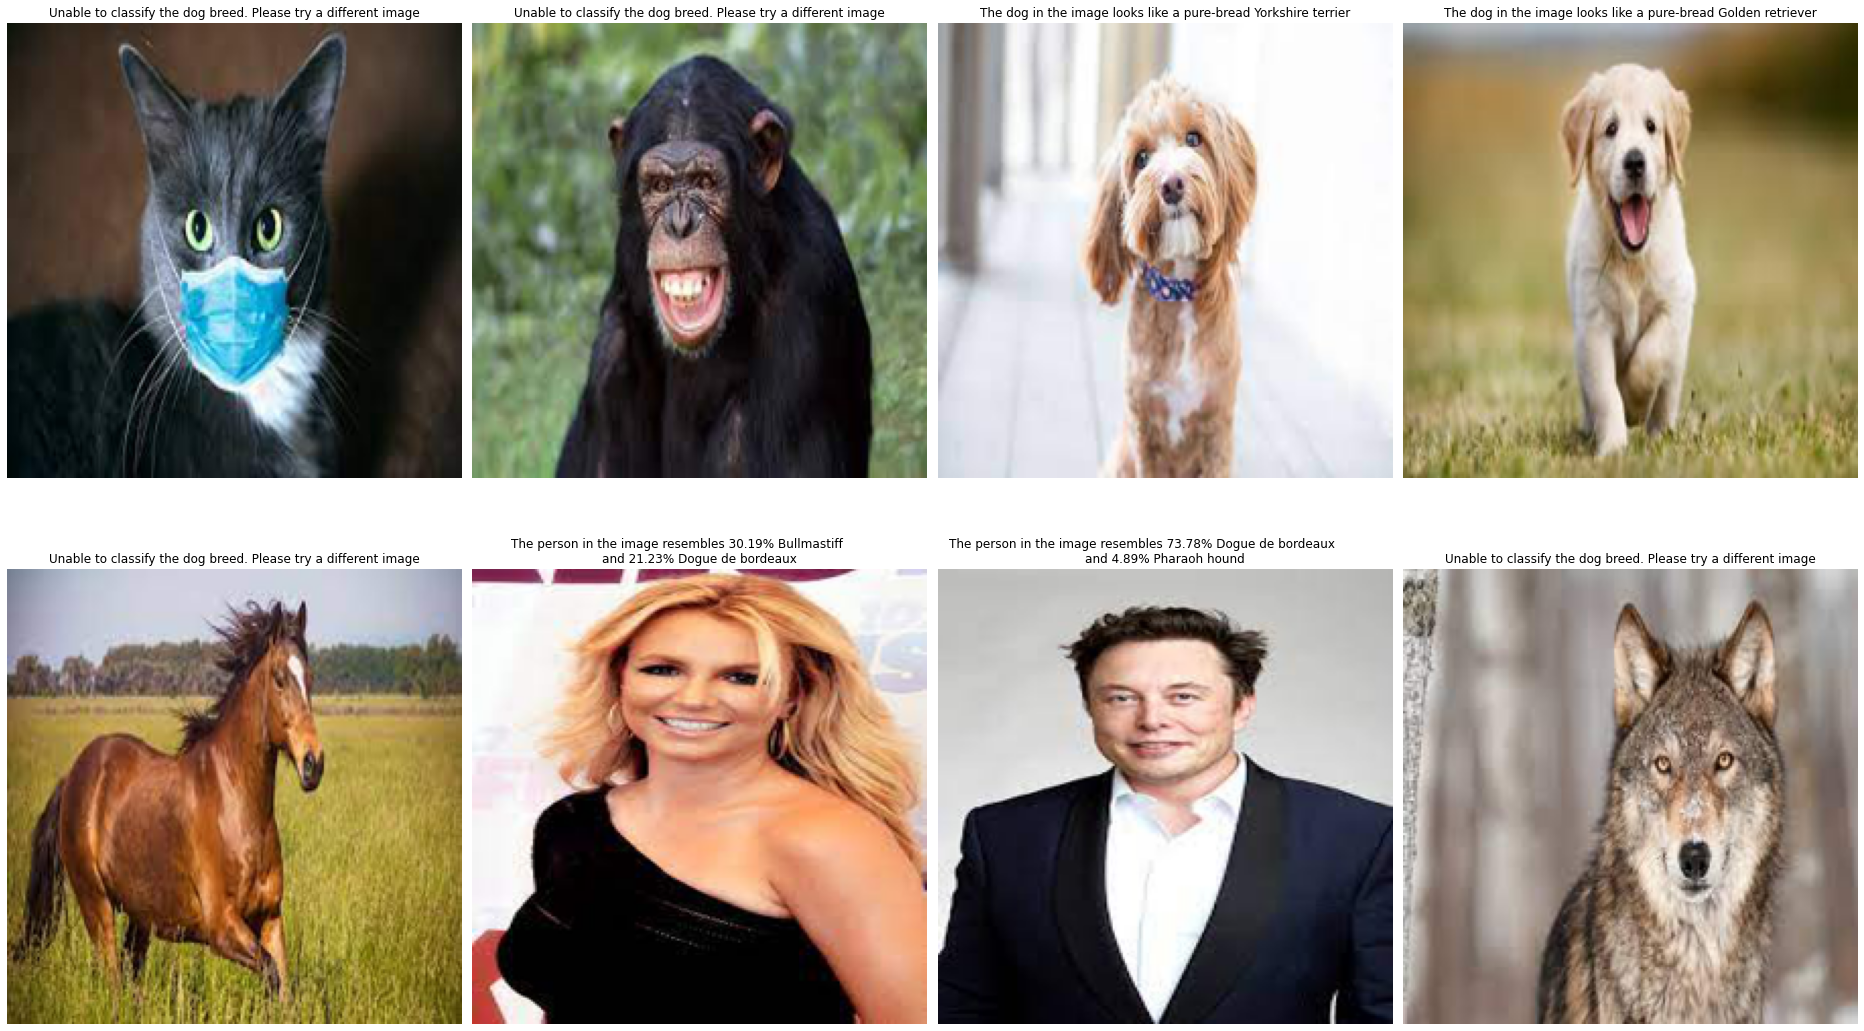

In [7]:
fig, ax = plt.subplots(2, 4, figsize=(26, 16))
flatax = ax.flatten()

for path, a in zip(added_paths, flatax):
    # ensure path is string
    path = str(path) 
    
    # load the images and 
    image = Image.open(path).resize(CROP)
    
    # run the app
    title = run_app(path)
    
    # display the answers
    a.imshow(image)
    a.set_title(title)
    a.set_axis_off()

plt.tight_layout()

In [10]:
dog_breed_model = torch.load('model_transfer.pt')
torch.save(dog_breed_model, 'model_h5.h5')